In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

import matplotlib.pyplot as plt
%matplotlib inline

import datetime as dt
import pickle
import os
import time

import seaborn as sns
sns.set()
from matplotlib import style
# style.use('ggplot')
%load_ext autoreload
%autoreload 2

# Pure LSTM for Time Series Only

In [2]:
train_arrs, test_arrs = [], []

arr_names = ["Xhist", "y", "dateticker"]

for arr_name in arr_names:
    fname = 'data/temporal_data/' + arr_name + "Train.npy"
    train_arrs.append(np.load(fname, allow_pickle=True))
    fname = 'data/temporal_data/' + arr_name + "Test.npy"
    test_arrs.append(np.load(fname, allow_pickle=True))
    
XseqTrain, yTrain, datetickerTrain = train_arrs
XseqTest, yTest, datetickerTest = test_arrs

print(XseqTrain.shape, XseqTest.shape, yTrain.shape, yTest.shape)

(498414, 128) (60412, 128) (498414, 1) (60412, 1)


In [3]:
import torch
import lstm_torch as lstm
from torch.utils.data import DataLoader, TensorDataset
bs = 64
timesteps = 50

# train_ds = SeqDataset(XseqTrain, yTrain, timesteps)
# test_ds = SeqDataset(XseqTest, yTest, timesteps)


x_train = torch.from_numpy(XseqTrain[:, -timesteps:, np.newaxis]).type(torch.Tensor)
x_test = torch.from_numpy(XseqTest[:, -timesteps:, np.newaxis]).type(torch.Tensor)
y_train = torch.from_numpy(yTrain.astype(np.float)).type(torch.Tensor)
y_test = torch.from_numpy(yTest.astype(np.float)).type(torch.Tensor)

train_ds = TensorDataset(x_train, y_train)
test_ds = TensorDataset(x_test, y_test)


train_dl = DataLoader(train_ds, bs, shuffle=True)
val_dl = DataLoader(test_ds, bs, shuffle=True)

# print('x_train.shape = ',x_train.shape)
# print('y_train.shape = ',y_train.shape)
# print('x_test.shape = ',x_test.shape)
# print('y_test.shape = ',y_test.shape)

In [15]:
model = lstm.LSTM(rnn_input_size=1, rnn_hidden_size=30, rnn_num_layers=3,
                 rnn_output_size=1, rnn_dropout=0.)
print(model)

LSTM(
  (rnn): LSTM(1, 30, num_layers=3, batch_first=True)
  (fc): Linear(in_features=30, out_features=1, bias=True)
)


In [5]:
# print([p.numel() for p in model.parameters() if p.requires_grad])
# print(sum(p.numel() for p in model.parameters()))

In [7]:
# lstm.train_model(model, train_dl, #one_cycle=True,
#             n_epochs=1, lr=1e-6, weight_decay=0.02)#, device="cpu")

In [16]:
lstm.train_model(model, train_dl, val_dl, n_epochs=2, lr=1e-3)#, weight_decay=0.02)

100%|██████████| 7788/7788 [01:02<00:00, 123.80it/s]


Epoch 1: training loss=0.00061


  0%|          | 10/7788 [00:00<01:21, 95.91it/s]

Epoch 1: val loss=0.00067


100%|██████████| 7788/7788 [01:03<00:00, 122.53it/s]


Epoch 2: training loss=0.00043
Epoch 2: val loss=0.00076


In [18]:
t0 = time.time()
train_preds, train_targets = lstm.predict(model, train_ds, 1024)
print(time.time() - t0)
# print(np.sum(train_targets[:, 0] != train_df['target_price']))

100%|██████████| 487/487 [00:07<00:00, 69.04it/s]

7.059804916381836


In [19]:
test_preds, test_targets = lstm.predict(model, test_ds, 1024)

100%|██████████| 59/59 [00:00<00:00, 69.11it/s]


In [20]:
import src.utils as utils

train_scores = utils.scores(train_targets, train_preds)
print('Training metrics:', train_scores)
test_scores = utils.scores(test_targets, test_preds)
print('Test metrics:', test_scores)

Training metrics: {'MAE': 0.015383683, 'MAPE': inf, 'RMSE': 0.021433765, 'RMSPE': inf}
Test metrics: {'MAE': 0.02185407, 'MAPE': inf, 'RMSE': 0.027599748, 'RMSPE': inf}


/home/wangxing/stock_forecast/src/utils.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs(y_hat-y) / y) * 100
/home/wangxing/stock_forecast/src/utils.py:89: RuntimeWarning: divide by zero encountered in true_divide
  return np.sqrt(np.mean(((y - y_hat) / y) ** 2))


In [24]:
df_pred_test = pd.DataFrame(datetickerTest, columns=['Date', 'ticker'])
df_pred_test['target_price'] = test_targets
df_pred_test['lstm_pred'] = test_preds

df_pred_test.to_csv('Results/lstm_test_preds.csv', index=False)
df_pred_test.tail()

,Date,ticker,target_price,lstm_pred
60407,2020-02-07,ZTS,0.977593,0.912055
60408,2020-02-10,ZTS,0.991468,0.941574
60409,2020-02-11,ZTS,0.981624,0.950292
60410,2020-02-12,ZTS,1.000000,0.944048
60411,2020-02-13,ZTS,0.992781,0.959658


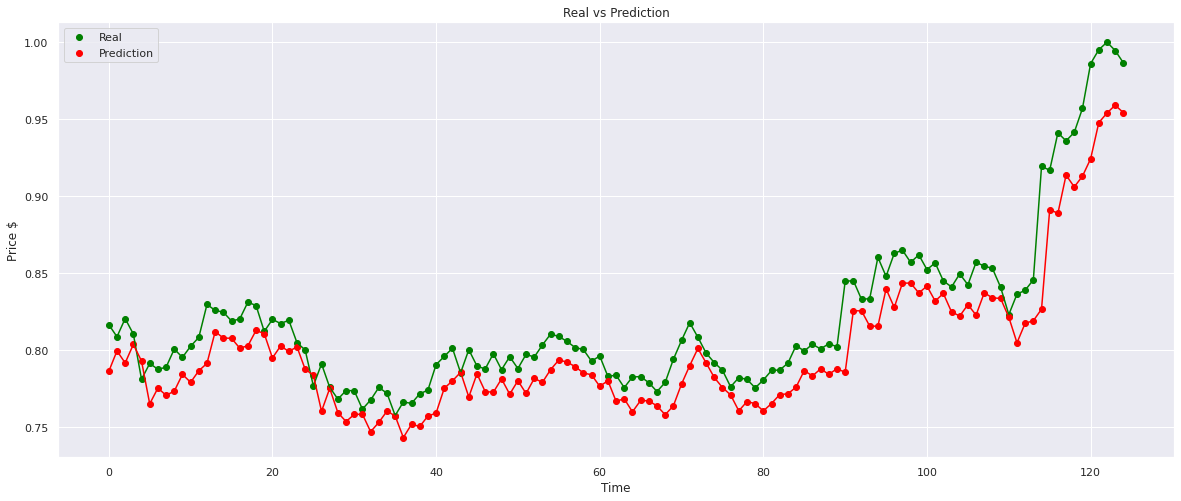

In [23]:
ticker = 'AMZN'
idx = df_pred_test[df_pred_test.ticker==ticker].index
y_plot_pred = df_pred_test.iloc[idx]['lstm_pred'].values
y_plot_real = df_pred_test.iloc[idx]['target_price'].values

n = len(y_plot_real)
fig, ax = plt.subplots(1,1, figsize=(20,8))
x_plot = np.arange(n)
plt.plot(x_plot, y_plot_real, color="green")
plt.scatter(x_plot, y_plot_real, c="green", label="Real")
plt.plot(x_plot, y_plot_pred, color="red")
plt.scatter(x_plot, y_plot_pred, c="red", label="Prediction")
plt.title("Real vs Prediction")
plt.xlabel("Time")
plt.ylabel("Price $")
plt.legend()
plt.show()

In [15]:
# PATH = './models/ts_lstm.mod'
# torch.save(model.state_dict(), PATH)

Pure LSTM for Time Series done here

# Hybrid LSTM

In [95]:
df = pd.read_csv('data_scaled.csv')
# df = df.drop(columns=["Return"])
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621391 entries, 0 to 621390
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Date                       621391 non-null  datetime64[ns]
 1   Adj Close                  621391 non-null  float64       
 2   volume_obv                 621391 non-null  float64       
 3   volume_fi                  621391 non-null  float64       
 4   volatility_bbm             621391 non-null  float64       
 5   volatility_bbw             621391 non-null  float64       
 6   volatility_bbhi            621391 non-null  float64       
 7   volatility_bbli            621391 non-null  float64       
 8   trend_macd                 621391 non-null  float64       
 9   trend_macd_signal          621391 non-null  float64       
 10  trend_macd_diff            621391 non-null  float64       
 11  trend_psar_up_indicator    621391 non-null  float64 

In [96]:
# def cat_cont_split(df, maxcard=55, omit_vars=['Date', 'Adj Close', 'Return', 'target_price']):
def cat_cont_split(df, maxcard=55, omit_vars=['Date', 'target_price']):
    """Helper function that returns column names of categorical & continuous features from df."""
    cat_feats, cont_feats = [], []
    for col in df:
        if col in omit_vars: 
            continue
        if (df[col].dtype==int or df[col].dtype==float) and df[col].unique().shape[0] > maxcard:
            cont_feats.append(col)
        else:
            cat_feats.append(col)
    return cat_feats, cont_feats
    
cat_vars, cont_vars = cat_cont_split(df)
print(len(cat_vars), 'Categorical Features:')
print(cat_vars)
print(len(cont_vars), 'Continuous Features:')
print(cont_vars)

18 Categorical Features:
['volatility_bbhi', 'volatility_bbli', 'trend_psar_up_indicator', 'trend_psar_down_indicator', 'ticker', 'sector', 'industry', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
12 Continuous Features:
['Adj Close', 'volume_obv', 'volume_fi', 'volatility_bbm', 'volatility_bbw', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'momentum_ao', 'momentum_roc', 'Dayofyear', 'Elapsed']


In [97]:
class Categorifier:
    ''' Transform categorical features into category types '''
    def apply_train(self, df, cat_vars):
        self.cat_vars = cat_vars
        self.categories = {}
        for v in self.cat_vars:
            df.loc[:, v] = df.loc[:, v].astype('category').cat.as_ordered()
            self.categories[v] = df[v].cat.categories
            
    def apply_test(self, df_test):
        for v in self.cat_vars:
            df_test.loc[:, v] = pd.Categorical(df[v], categories=self.categories[v], ordered=True)

cat = Categorifier()
cat.apply_train(df, cat_vars)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621391 entries, 0 to 621390
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Date                       621391 non-null  datetime64[ns]
 1   Adj Close                  621391 non-null  float64       
 2   volume_obv                 621391 non-null  float64       
 3   volume_fi                  621391 non-null  float64       
 4   volatility_bbm             621391 non-null  float64       
 5   volatility_bbw             621391 non-null  float64       
 6   volatility_bbhi            621391 non-null  category      
 7   volatility_bbli            621391 non-null  category      
 8   trend_macd                 621391 non-null  float64       
 9   trend_macd_signal          621391 non-null  float64       
 10  trend_macd_diff            621391 non-null  float64       
 11  trend_psar_up_indicator    621391 non-null  category

In [98]:
dep_var = 'target_price'
cont_vars = cont_vars
cat_sz = [(nc, len(df[nc].cat.categories)+1) for nc in cat_vars]
# emb_szs = [(nc, min(50, (nc+1)//2)) for _, nc in cat_sz]
emb_szs = [(nc, min(51, round(1.6*nc**0.56))) for _, nc in cat_sz]

In [99]:
cont_vars

['Adj Close',
 'volume_obv',
 'volume_fi',
 'volatility_bbm',
 'volatility_bbw',
 'trend_macd',
 'trend_macd_signal',
 'trend_macd_diff',
 'momentum_ao',
 'momentum_roc',
 'Dayofyear',
 'Elapsed']

In [100]:
train_arrs, test_arrs = [], []

arr_names = ["Xhist", "Xcat", "Xcont", "y", "dateticker"]

for arr_name in arr_names:
    fname = 'data/temporal_data/' + arr_name + "Train.npy"
    train_arrs.append(np.load(fname, allow_pickle=True))
    fname = 'data/temporal_data/' + arr_name + "Test.npy"
    test_arrs.append(np.load(fname, allow_pickle=True))
    
XseqTrain, XcatTrain, XcontTrain, yTrain, datetickerTrain = train_arrs
XseqTest, XcatTest, XcontTest, yTest, datetickerTest = test_arrs

print(XseqTrain.shape, XseqTest.shape, yTrain.shape, yTest.shape)

(498414, 128) (60412, 128) (498414, 1) (60412, 1)


In [101]:
print(XcontTrain.shape, XcontTest.shape)

(498414, 12) (60412, 12)


In [102]:
np.vstack([yTrain, yTest]).shape

(558826, 1)

In [103]:
import hybrid_lstm
from torch.utils.data import DataLoader
bs = 64
timesteps = 50

train_ds = hybrid_lstm.HybridDataset(XcatTrain, XcontTrain, XseqTrain, yTrain, timesteps)
train_ds = hybrid_lstm.HybridDataset(np.vstack([XcatTrain, XcatTest]), 
                                     np.vstack([XcontTrain, XcontTest]),
                                     np.vstack([XseqTrain, XseqTest]),
                                     np.vstack([yTrain,yTest]), timesteps)

test_ds = hybrid_lstm.HybridDataset(XcatTest, XcontTest, XseqTest, yTest, timesteps)

train_dl = DataLoader(train_ds, bs, shuffle=True)
val_dl = DataLoader(test_ds, 1024, shuffle=True)

In [104]:
model_lstm = hybrid_lstm.LSTMHybrid(emb_szs, len(cont_vars), hidden_sizes=[1024, 512], 
                emb_dropout = 0.1, dropout_prob = [0.001, .01], use_bn=True,
                rnn_input_size=1, rnn_hidden_size=30, rnn_num_layers=3,
                rnn_output_size=20, rnn_dropout=0.)
print(model_lstm)

LSTMHybrid(
  (rnn): LSTM(1, 30, num_layers=3, batch_first=True)
  (fc_rnn): Linear(in_features=30, out_features=20, bias=True)
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(3, 3)
    (2): Embedding(3, 3)
    (3): Embedding(3, 3)
    (4): Embedding(486, 51)
    (5): Embedding(13, 7)
    (6): Embedding(105, 22)
    (7): Embedding(7, 5)
    (8): Embedding(13, 7)
    (9): Embedding(54, 15)
    (10): Embedding(32, 11)
    (11): Embedding(6, 4)
    (12): Embedding(3, 3)
    (13): Embedding(3, 3)
    (14): Embedding(3, 3)
    (15): Embedding(3, 3)
    (16): Embedding(3, 3)
    (17): Embedding(2, 2)
  )
  (emb_dropout): Dropout(p=0.1, inplace=False)
  (bn_cont): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=183, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001,

In [105]:
hybrid_lstm.train_model(model_lstm, train_dl, val_dl, 
            n_epochs=2, lr=1e-3)

100%|██████████| 8732/8732 [02:02<00:00, 71.57it/s]


Epoch 1: training loss=0.01829


  0%|          | 4/8732 [00:00<03:44, 38.89it/s]

Epoch 1: val loss=0.00129


100%|██████████| 8732/8732 [02:02<00:00, 71.08it/s]


Epoch 2: training loss=0.00220
Epoch 2: val loss=0.00057


In [112]:
hybrid_lstm.train_model(model_lstm, val_dl, n_epochs=10, lr=1e-3)

  5%|▌         | 3/59 [00:00<00:02, 26.22it/s]

Epoch 1: training loss=0.00650


  5%|▌         | 3/59 [00:00<00:02, 26.54it/s]

Epoch 2: training loss=0.00076


  5%|▌         | 3/59 [00:00<00:02, 25.47it/s]

Epoch 3: training loss=0.00069


  5%|▌         | 3/59 [00:00<00:02, 23.21it/s]

Epoch 4: training loss=0.00069


  5%|▌         | 3/59 [00:00<00:02, 23.45it/s]

Epoch 5: training loss=0.00067


  5%|▌         | 3/59 [00:00<00:02, 24.88it/s]

Epoch 6: training loss=0.00061


  5%|▌         | 3/59 [00:00<00:02, 26.84it/s]

Epoch 7: training loss=0.00067


  5%|▌         | 3/59 [00:00<00:02, 26.07it/s]

Epoch 8: training loss=0.00062


  5%|▌         | 3/59 [00:00<00:02, 26.29it/s]

Epoch 9: training loss=0.00063


100%|██████████| 59/59 [00:02<00:00, 27.47it/s]

Epoch 10: training loss=0.00068


In [123]:
train_preds, train_targets = hybrid_lstm.predict(model_lstm, train_ds, 512)
test_preds, test_targets = hybrid_lstm.predict(model_lstm, test_ds, 512)

100%|██████████| 118/118 [00:01<00:00, 83.84it/s]


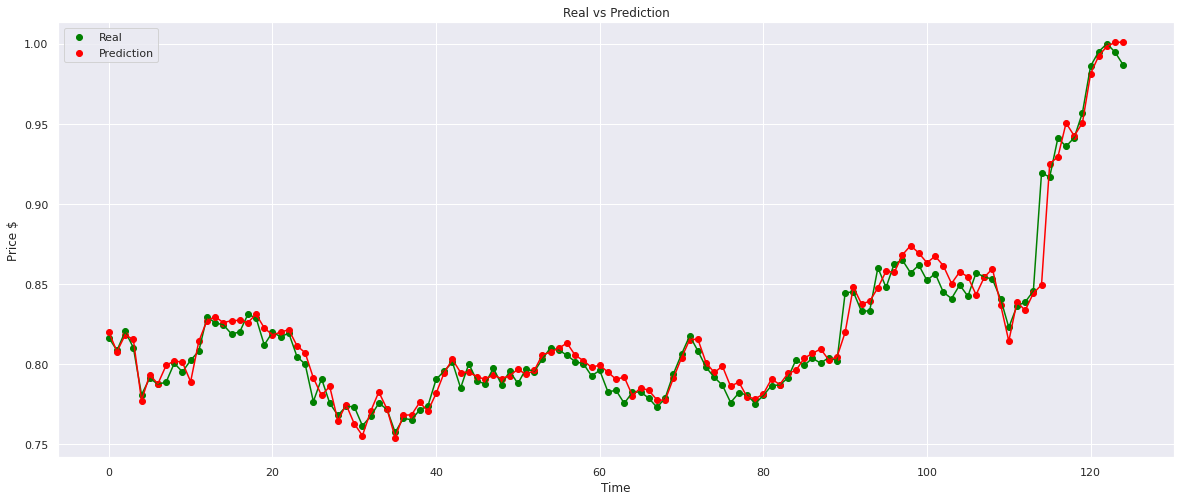

In [125]:
df_pred_test = pd.DataFrame(datetickerTest, columns=['Date', 'ticker'])
df_pred_test['target_price'] = test_targets
df_pred_test['lstm'] = test_preds
# df_pred_test.head()

ticker = 'AMZN'
idx = df_pred_test[df_pred_test.ticker==ticker].index
y_plot_pred = df_pred_test.iloc[idx]['lstm'].values
y_plot_real = df_pred_test.iloc[idx]['target_price'].values

n = len(y_plot_real)
fig, ax = plt.subplots(1,1, figsize=(20,8))
x_plot = np.arange(n)
plt.plot(x_plot, y_plot_real, color="green")
plt.scatter(x_plot, y_plot_real, c="green", label="Real")
plt.plot(x_plot, y_plot_pred, color="red")
plt.scatter(x_plot, y_plot_pred, c="red", label="Prediction")
plt.title("Real vs Prediction")
plt.xlabel("Time")
plt.ylabel("Price $")
plt.legend()
plt.show()

In [126]:
df_pred_test = pd.DataFrame(datetickerTest, columns=['Date', 'ticker'])
df_pred_test['target_price'] = test_targets
df_pred_test['rs2v_pred'] = test_preds

df_pred_test.to_csv('Results/lstm_s2v_test_preds.csv', index=False)
df_pred_test.tail()

,Date,ticker,target_price,rs2v_pred
60407,2020-02-07,ZTS,0.977593,0.962557
60408,2020-02-10,ZTS,0.991468,0.991075
60409,2020-02-11,ZTS,0.981624,0.994530
60410,2020-02-12,ZTS,1.000000,0.993011
60411,2020-02-13,ZTS,0.992781,1.005925
